In [1]:
import torch
import pickle
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, perturb_matrices
import numpy as np

In [2]:
# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [3]:
set_seed(42)
nx, nu, ny = 2, 1, 1  # Example dimensions, modify as needed
G_0 = drss(nx, nu, ny)
perturb_percentage = 50

In [4]:
G_0

(tensor([[ 0.0194,  0.2161],
         [-0.0172,  0.0849]], device='cuda:0'),
 tensor([[ 0.1391],
         [-0.1082]], device='cuda:0'),
 tensor([[-0.5187,  1.2268]], device='cuda:0'),
 tensor([[-0.]], device='cuda:0'))

In [5]:
# Generate a test set of 20 perturbed matrices
test_set = []
for _ in range(30):
    perturbed_matrix = perturb_matrices(*G_0, percentage=perturb_percentage, device=device)
    test_set.append(perturbed_matrix)

# Save the test set using pickle
with open('test_set_lin_1.pkl', 'wb') as f:
    pickle.dump(test_set, f)

print("Test set of perturbed matrices saved successfully.")

Test set of perturbed matrices saved successfully.


In [7]:
import os

file_path = 'test_set_lin_1.pkl'
print(f"File size: {os.path.getsize(file_path)} bytes")

File size: 36445 bytes


In [8]:
# Load the test set from the pickle file
with open('test_set_lin_1.pkl', 'rb') as f:
    test_set = pickle.load(f)

/home/rbusetto/.virtualenvs/in-context-controller/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.Bytes

In [9]:
from control_torch import drss, forced_response, tf2ss, c2d, perturb_matrices, set_seed, perturb_parameters
from signals_torch import steps_sequence
import matplotlib.pyplot as plt

In [10]:
## PLOT STEP RESPONSE TO ENSURE STABILITY
Y = torch.empty((30, 500), device=device, dtype=torch.float32)
x_i = torch.zeros((30, 2), device=device, dtype=torch.float32)
u = torch.full((500,), 10, device=device, dtype=torch.float32)
u = u.reshape(-1, 1)
u[:50] = 0
for j, system in enumerate(test_set):
    y = forced_response(*system, u, x0=x_i[j])
    if y.dim() == 2 and y.size(1) == 1:
        y = y.squeeze(1)  # Remove the second dimension if it has size 1
    Y[j] = y


/tmp/ipykernel_17867/4267621663.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Show legend


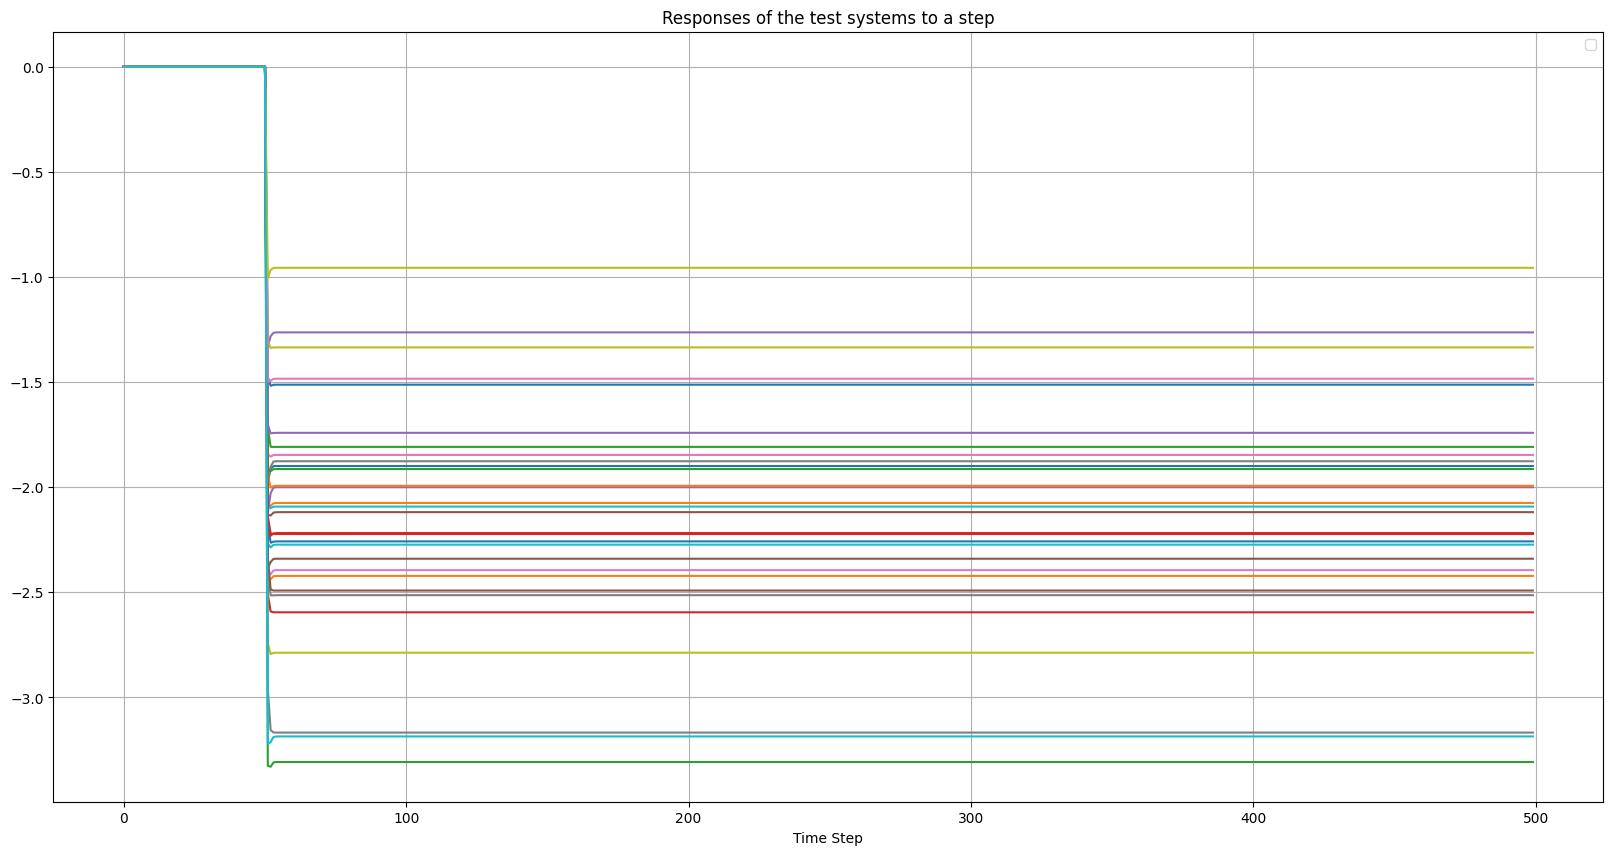

In [11]:
plt.figure(figsize=(20, 10))  # Set the figure size
for i in range(Y.shape[0]):
    plt.plot(Y[i].cpu().numpy())

plt.xlabel('Time Step')  # X-axis label
plt.title('Responses of the test systems to a step')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  
plt.show()  # 